In [52]:
# import statements

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

In [2]:
# function because some of the simulations have a messed-up calendar
def fix_xtime(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-02 00:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-02 00:00:00"
    return(ds_in)

# function to read in data
def load(path: str) -> xr.Dataset:
    return(xr.decode_cf(
        xr.open_mfdataset(path,preprocess=fix_xtime,
                          decode_times=False,combine="nested",concat_dim='Time')
                          )
    )

In [3]:
runs_list = []
# iterate through ensemble members
for i in range(1,19):
    path = "/mnt/drive2/wof-runs/00Z/wrfwof*.{:02d}".format(i)
    runs_list.append(load(path))

# create new "ens" dimension
runs = xr.concat(runs_list,"ens")

In [4]:
# separate a few variables
rainnc = runs.metpy.parse_cf("RAINNC").load()
heli02 = runs.metpy.parse_cf("UP_HELI_MAX02").load()
lat = runs.XLAT.isel(Time=0)
lon = runs.XLONG.isel(Time=0)

In [5]:
# get central latitude and longitude for projections
central_latitude = float(lat.mean())
central_longitude = float(lon.mean())

/tmp/ipykernel_1099870/3300489540.py:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


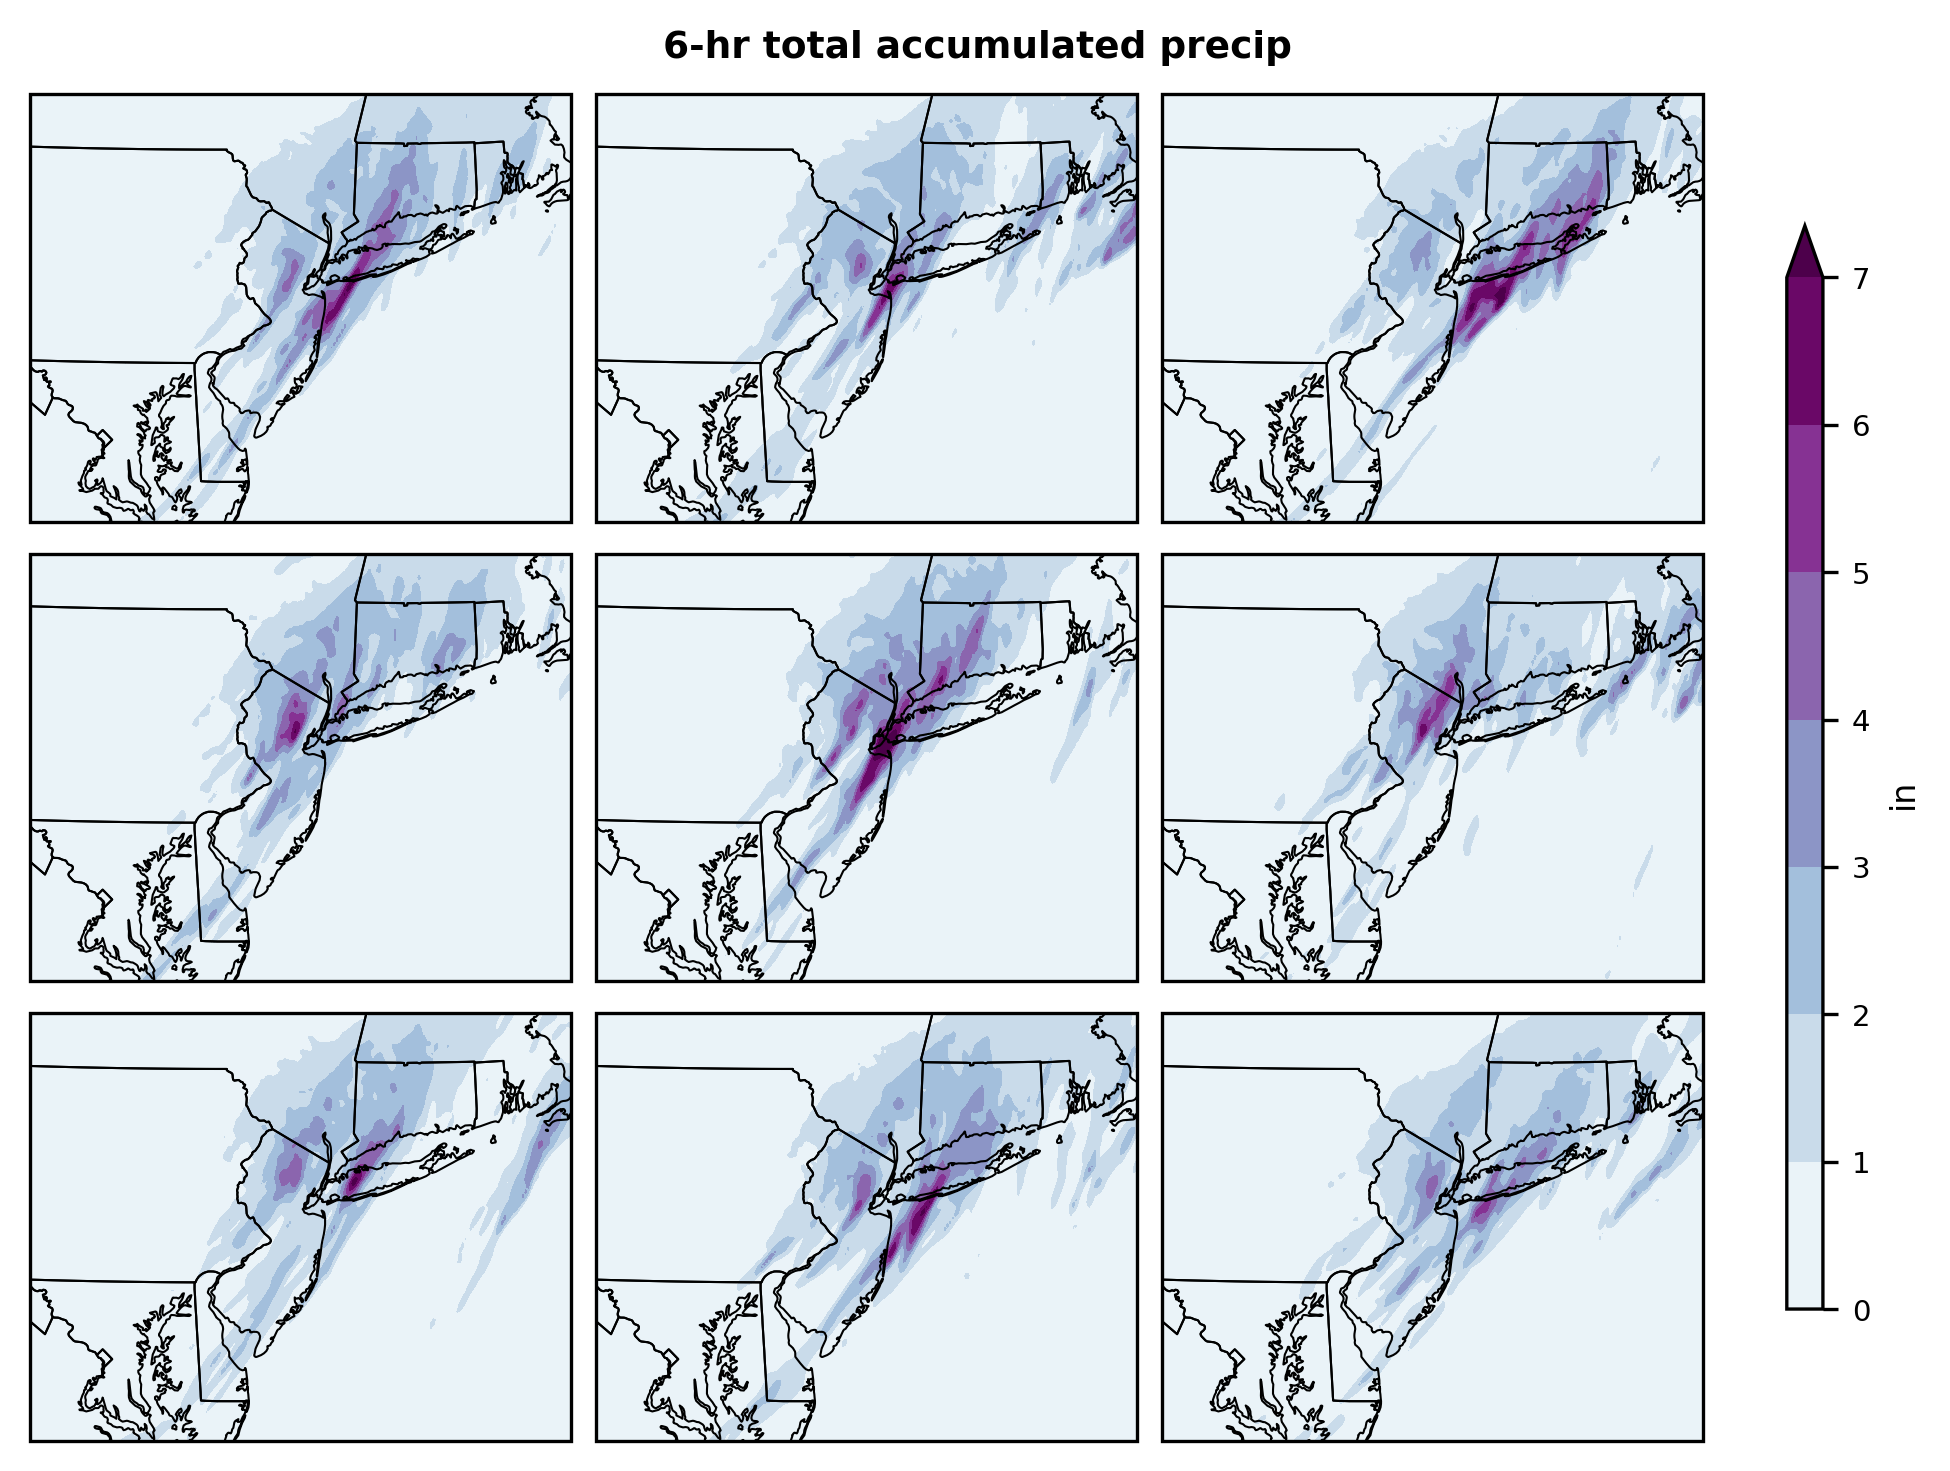

In [13]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
for i,ax in enumerate(axes.flatten()):
    p = ax.contourf(lon,lat,rainnc.isel(Time=-1,ens=i)/25.4,
                    transform=ccrs.PlateCarree(),
                    cmap="BuPu",levels=np.arange(0,7.1,1),
                    extend="max")
    p.axes.set_extent(region,crs=ccrs.PlateCarree())
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    # p.axes.add_feature(cfeature.GSHHSFeature(scale="i"),linewidth=linewidth)
plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("6-hr total accumulated precip",fontsize=9,fontweight='bold')
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("in",fontsize=8)
plt.show()

/tmp/ipykernel_1099870/3300489540.py:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


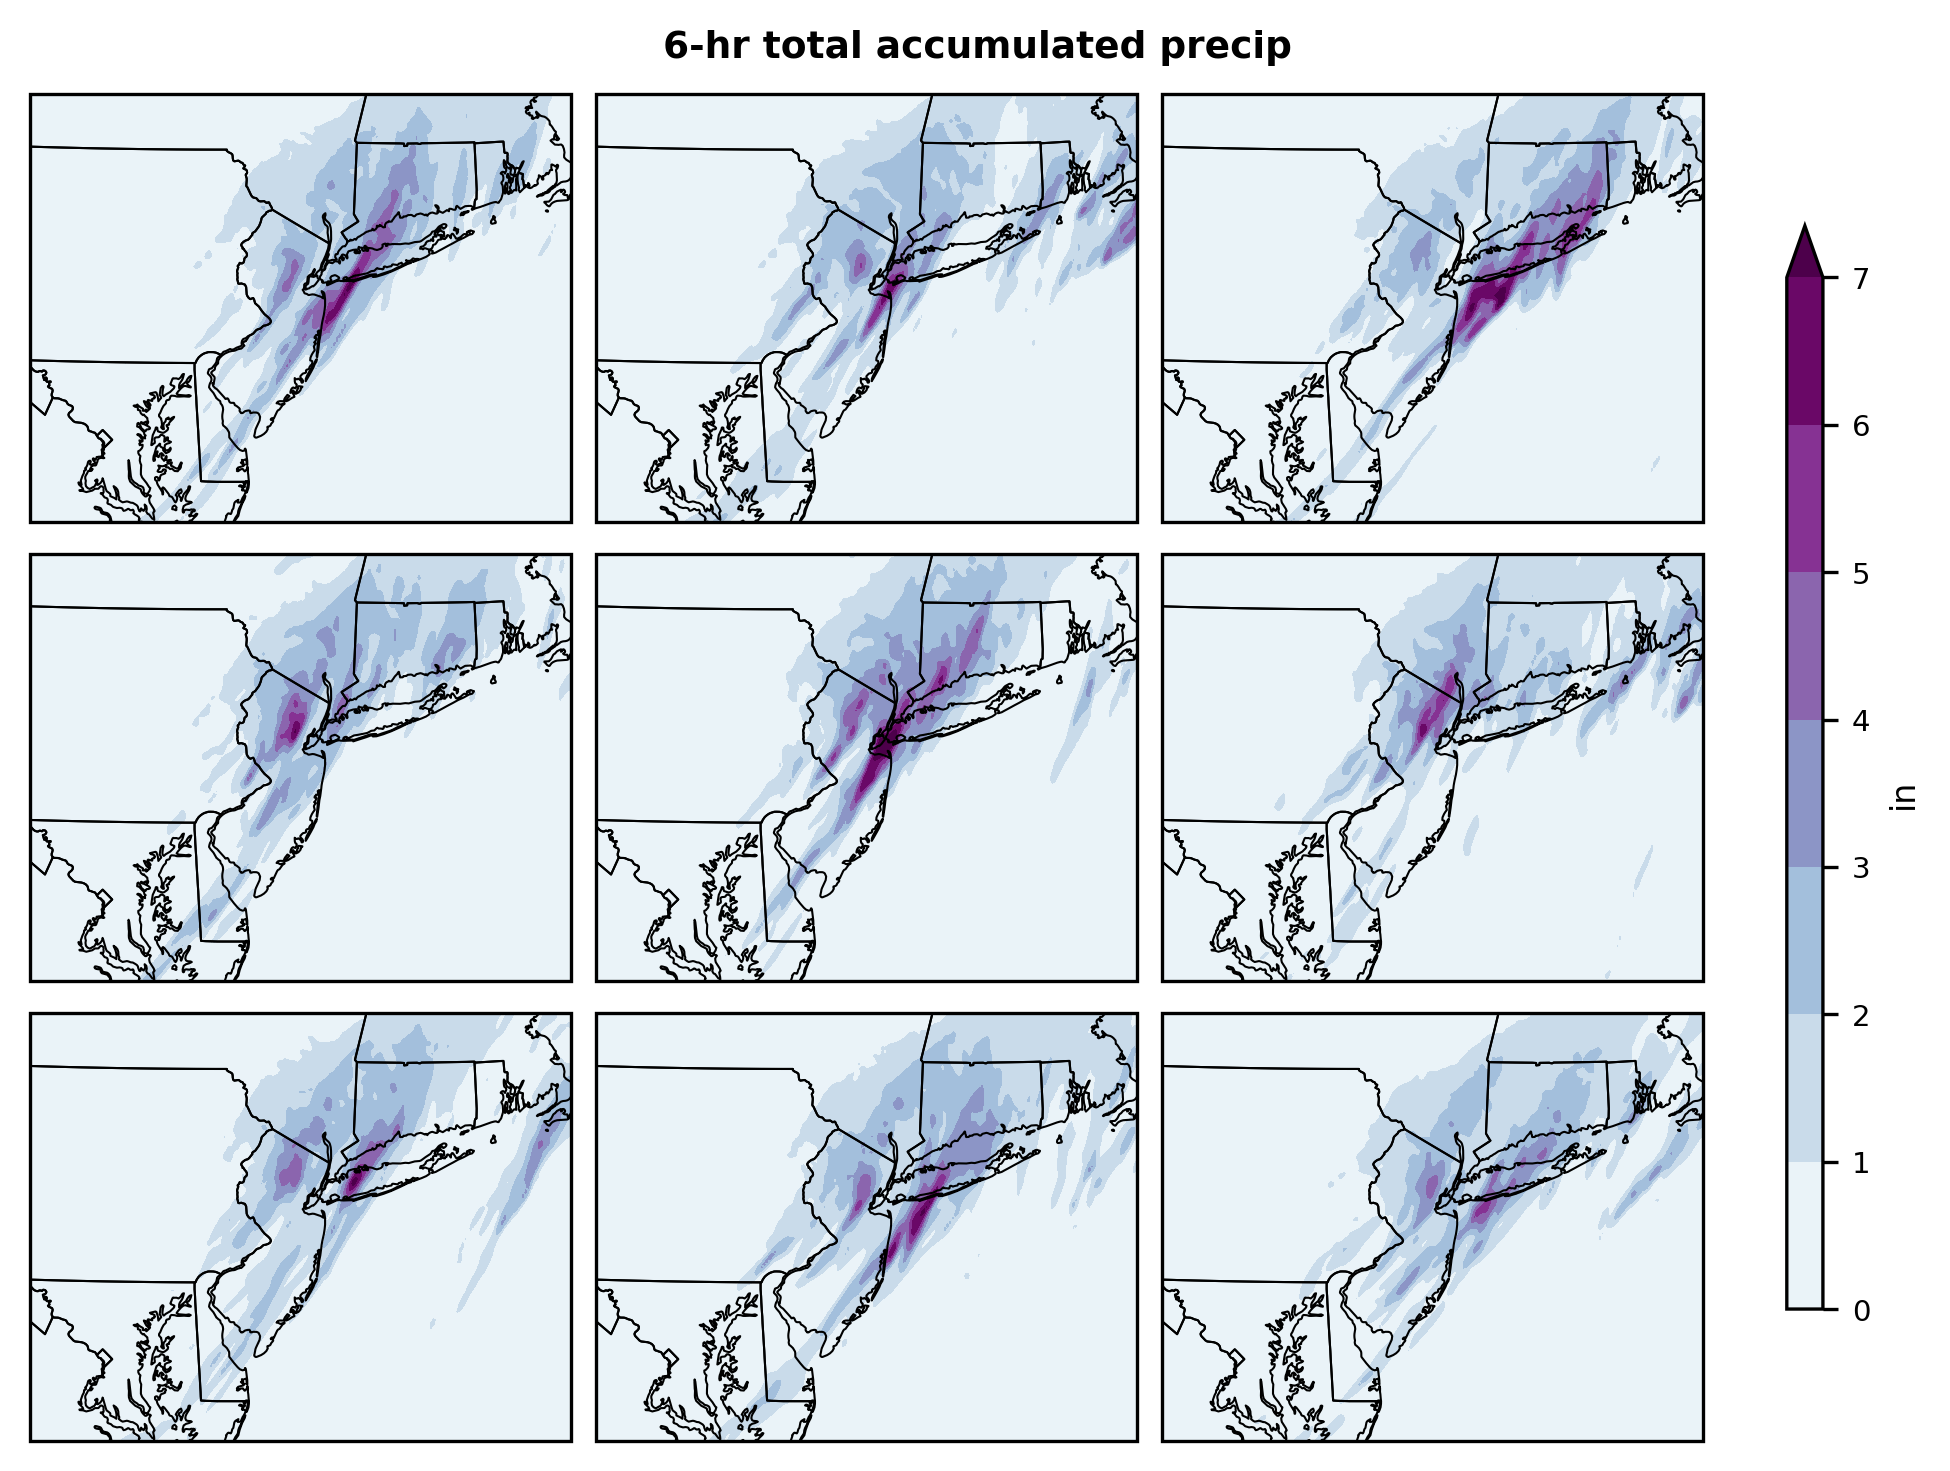

In [17]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
for i,ax in enumerate(axes.flatten()):
    p = ax.contourf(lon,lat,rainnc.isel(Time=-1,ens=i)/25.4,
                    transform=ccrs.PlateCarree(),
                    cmap="BuPu",levels=np.arange(0,7.1,1),
                    extend="max")
    p.axes.set_extent(region,crs=ccrs.PlateCarree())
    p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    # p.axes.add_feature(cfeature.GSHHSFeature(scale="i"),linewidth=linewidth)
plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("6-hr total accumulated precip",fontsize=9,fontweight='bold')
cbar = fig.colorbar(p,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("in",fontsize=8)
plt.show()

In [18]:
max_locs = heli02.argmax(dim=['south_north','west_east'])
lats = runs.XLAT.sel(south_north=max_locs['south_north'],
                     west_east=max_locs['west_east'])
lons = runs.XLONG.sel(south_north=max_locs['south_north'],
                     west_east=max_locs['west_east'])

/tmp/ipykernel_1099870/2013372022.py:17: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


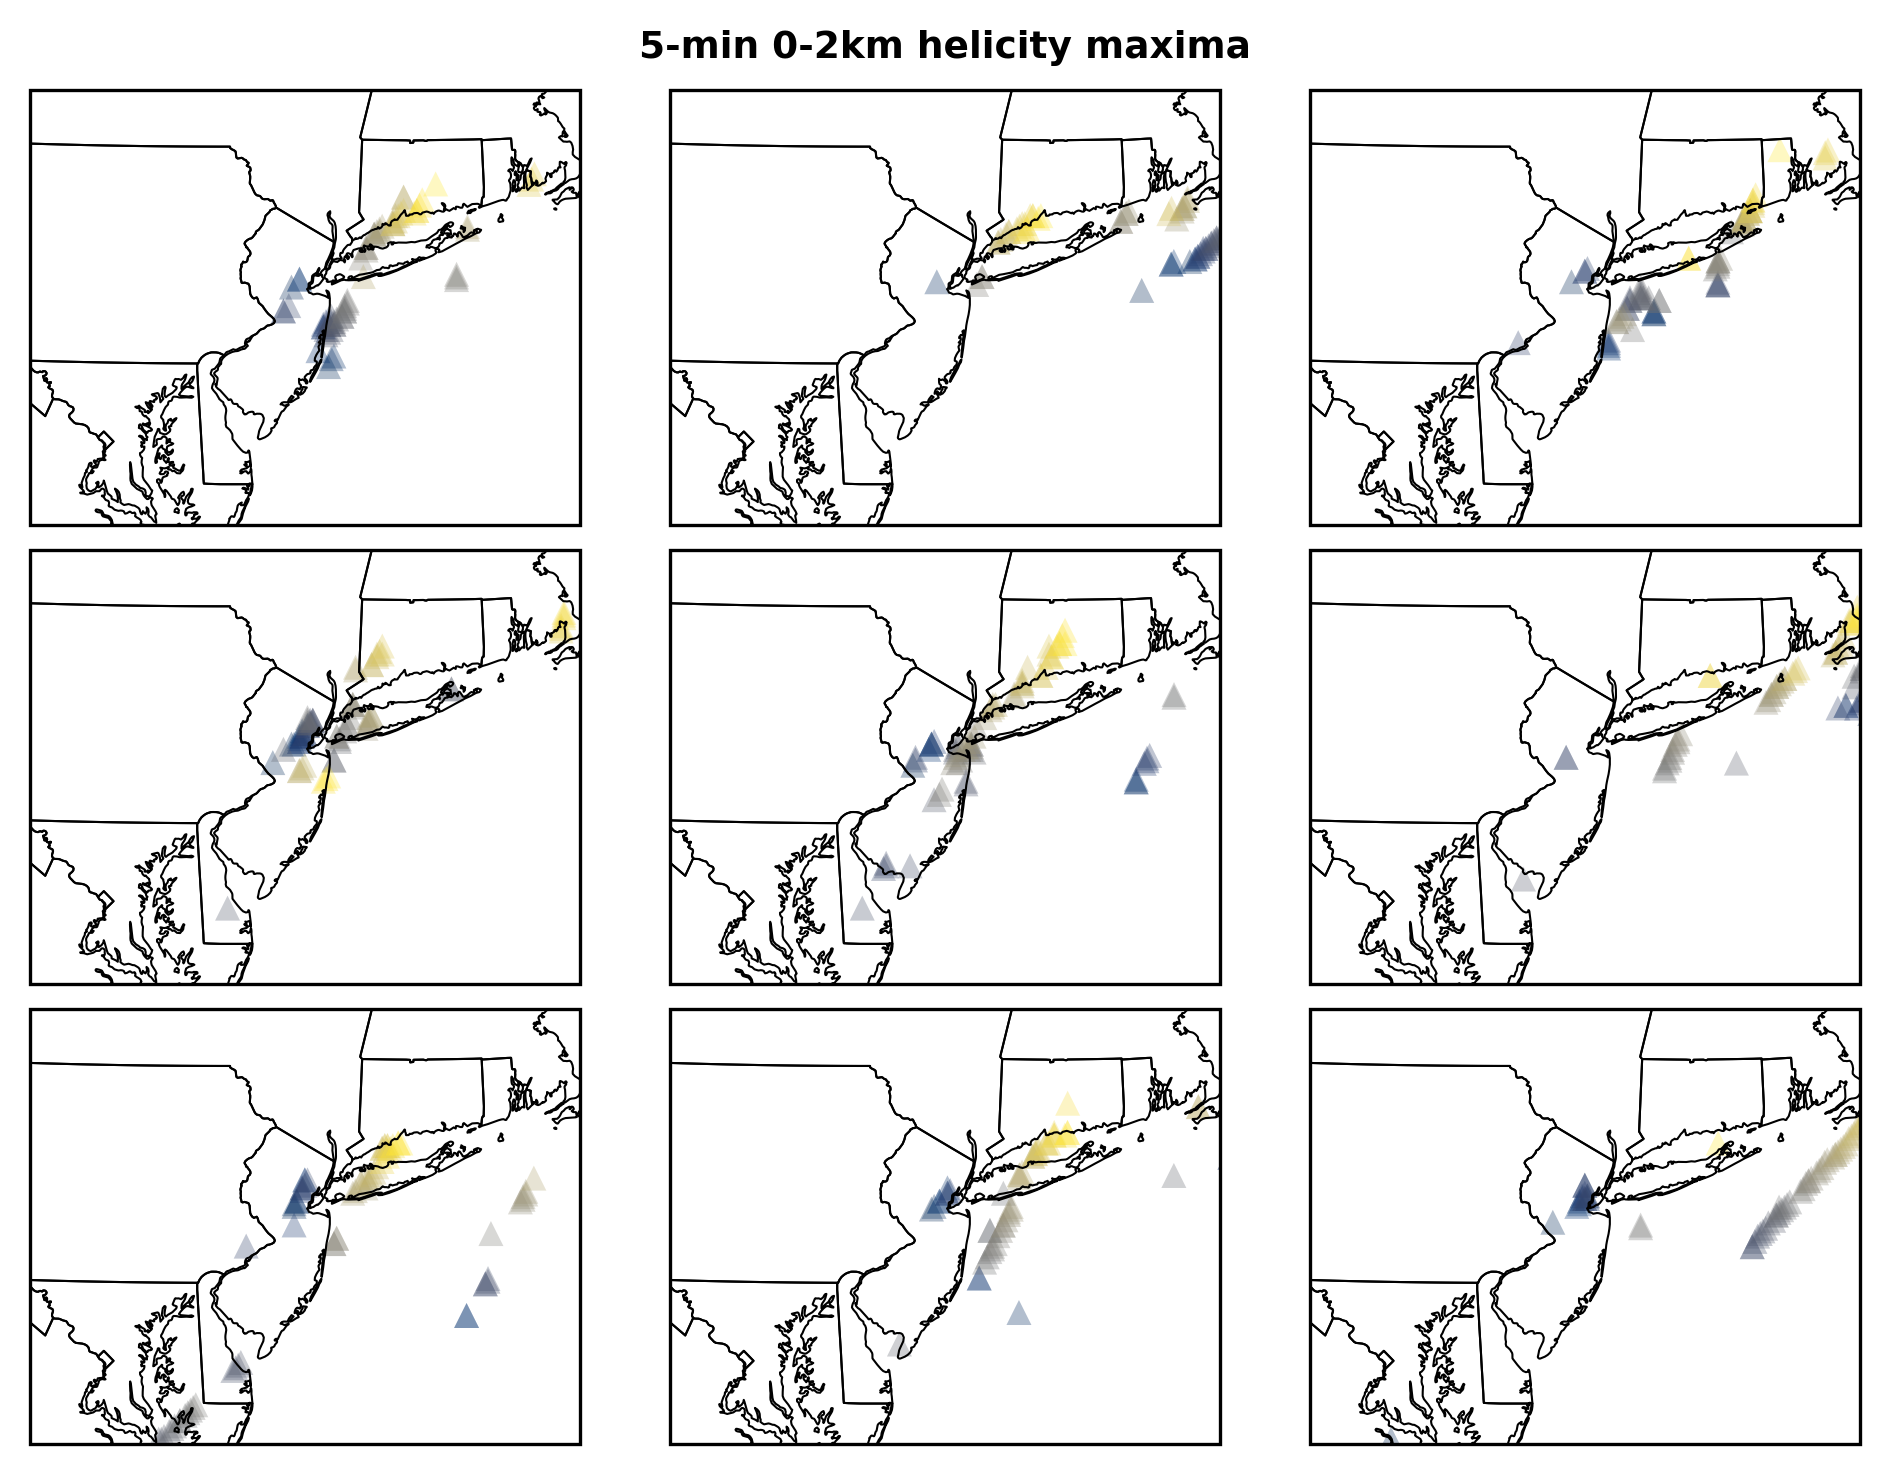

In [19]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, axes = plt.subplots(3, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
for i,ax in enumerate(axes.flatten()):
    s = ax.scatter(lons.isel(ens=i),lats.isel(ens=i),
                     transform=ccrs.PlateCarree(),
                     alpha=0.3,c=runs.XTIME,cmap='cividis',
                     marker='^',edgecolors='none')
    s.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    s.axes.set_extent(region,crs=ccrs.PlateCarree())
plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("5-min 0-2km helicity maxima",fontsize=9,fontweight='bold')
plt.show()


### Probability of exceedance

In [29]:
rainnc_6hr = rainnc.isel(Time=-1)
gt_3in = (rainnc_6hr > 76.20).sum(dim='ens') / len(rainnc_6hr.ens)
gt_3in_9km = ((rainnc_6hr > 76.20).sum(dim='ens') / len(rainnc_6hr.ens)).rolling(
    south_north=3,west_east=3).max()

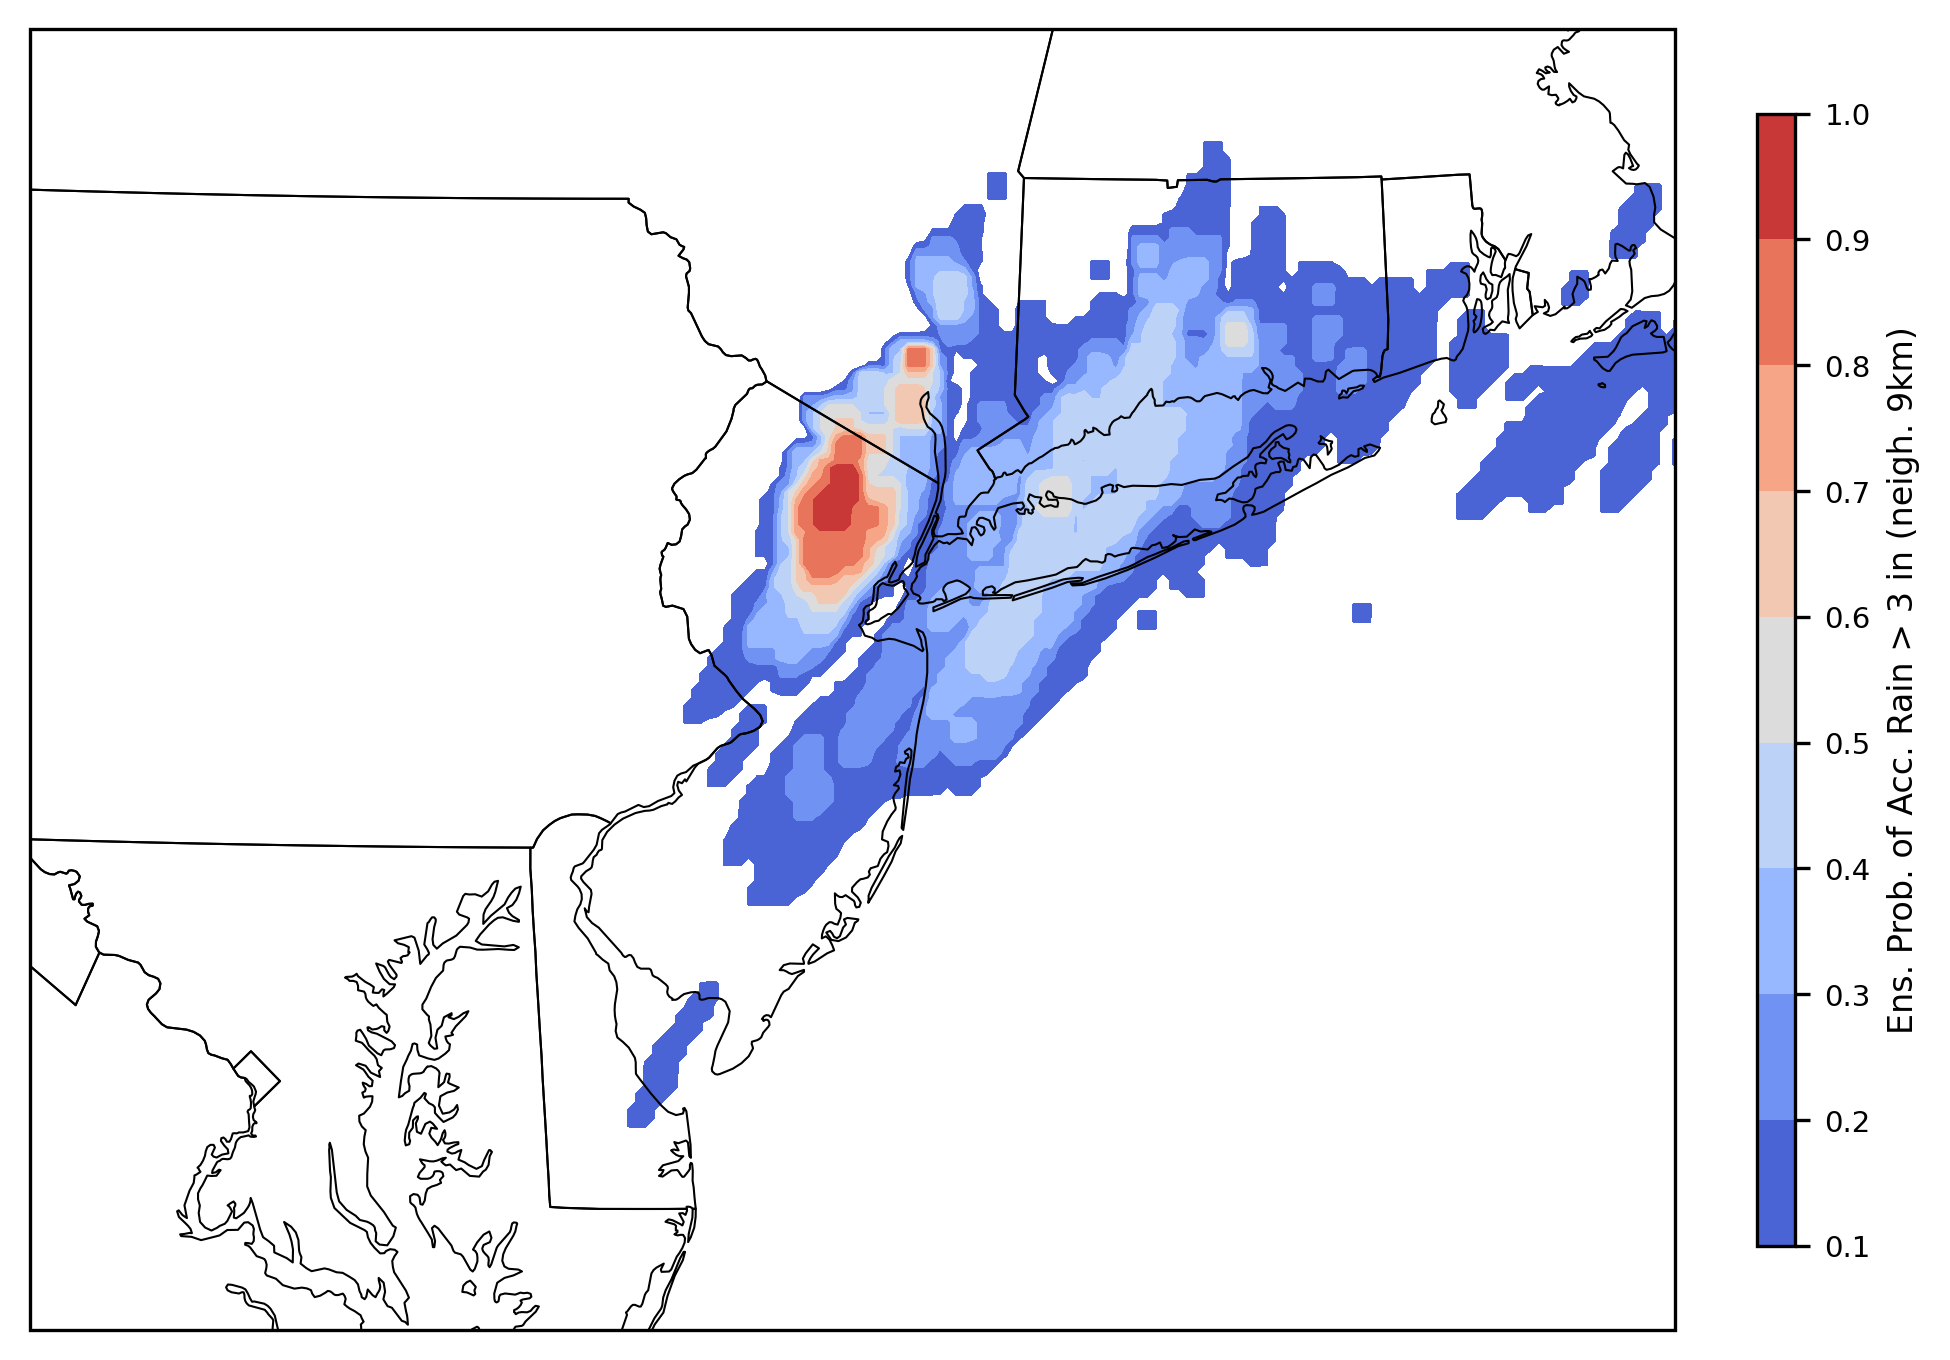

In [31]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
p = ax.contourf(lon,lat,gt_3in_9km,
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",levels=np.arange(0.1,1.1,0.1),
                # extend="max")
)
p.axes.set_extent(region,crs=ccrs.PlateCarree())
p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
# plt.subplots_adjust(wspace=0.04,hspace=0.04)
# plt.suptitle("5-min 0-2km helicity maxima",fontsize=9,fontweight='bold')

cbar = fig.colorbar(p,ax=ax,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Ens. Prob. of Acc. Rain > 3 in (neigh. 9km)",fontsize=8)

plt.show()

In [22]:
gt_20_9km = ((heli02 > 20).max(dim='Time').sum(dim='ens') / len(heli02.ens)).rolling(
    south_north=3,west_east=3).max()

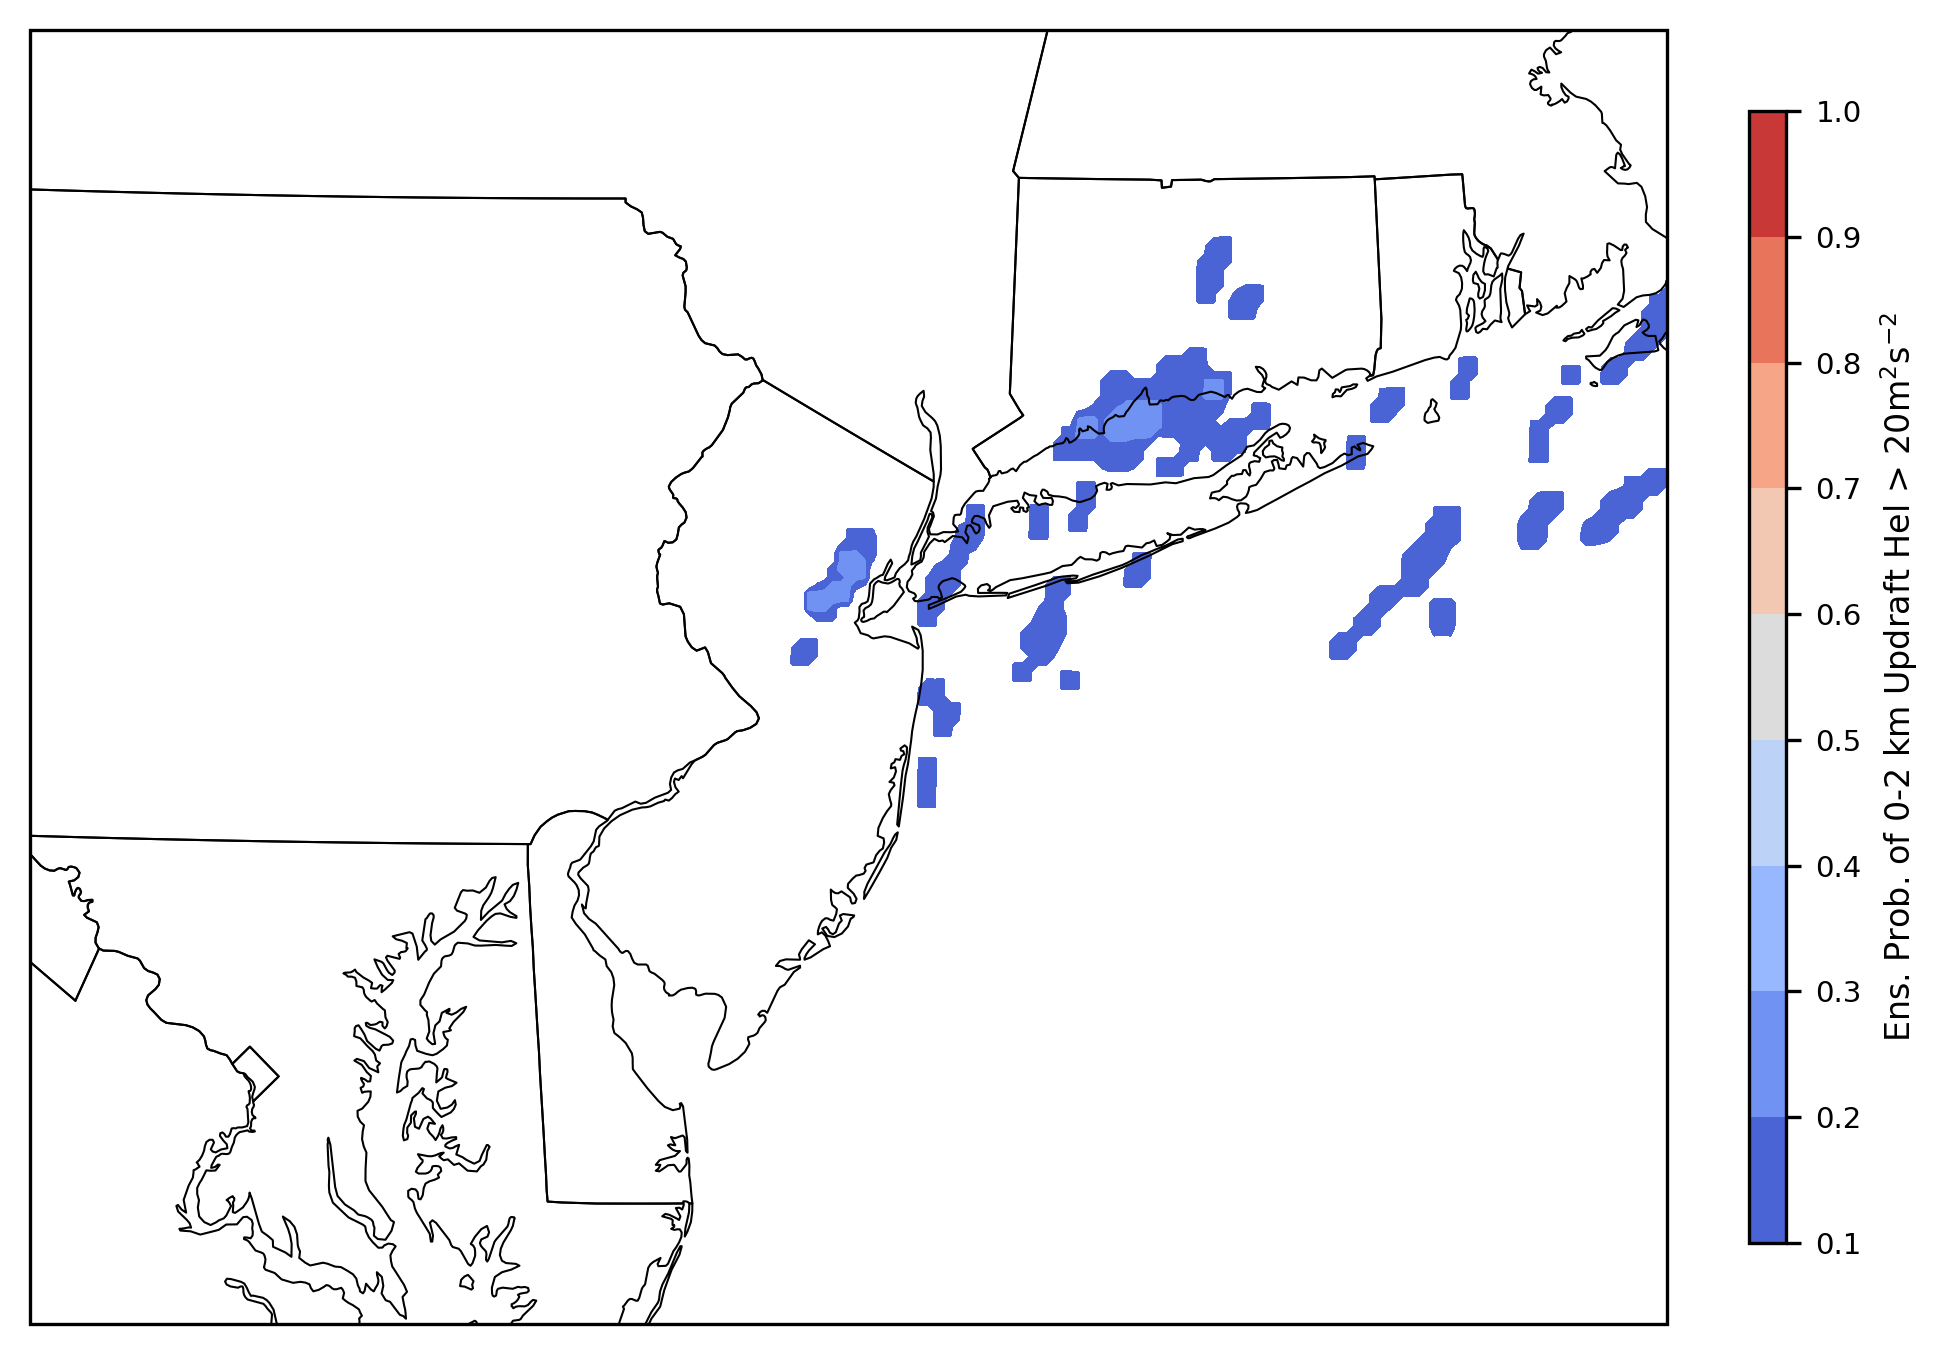

In [23]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
p = ax.contourf(lon,lat,gt_20_9km,
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",levels=np.arange(0.1,1.1,0.1),
                # extend="max")
)
p.axes.set_extent(region,crs=ccrs.PlateCarree())
p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
# plt.subplots_adjust(wspace=0.04,hspace=0.04)
# plt.suptitle("5-min 0-2km helicity maxima",fontsize=9,fontweight='bold')

cbar = fig.colorbar(p,ax=ax,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Ens. Prob. of 0-2 km Updraft Hel > 20m$^2$s$^{-2}$",fontsize=8)

plt.show()

### Percentiles & Max

In [24]:
rainnc_90 = rainnc_6hr.quantile(0.9,dim='ens')

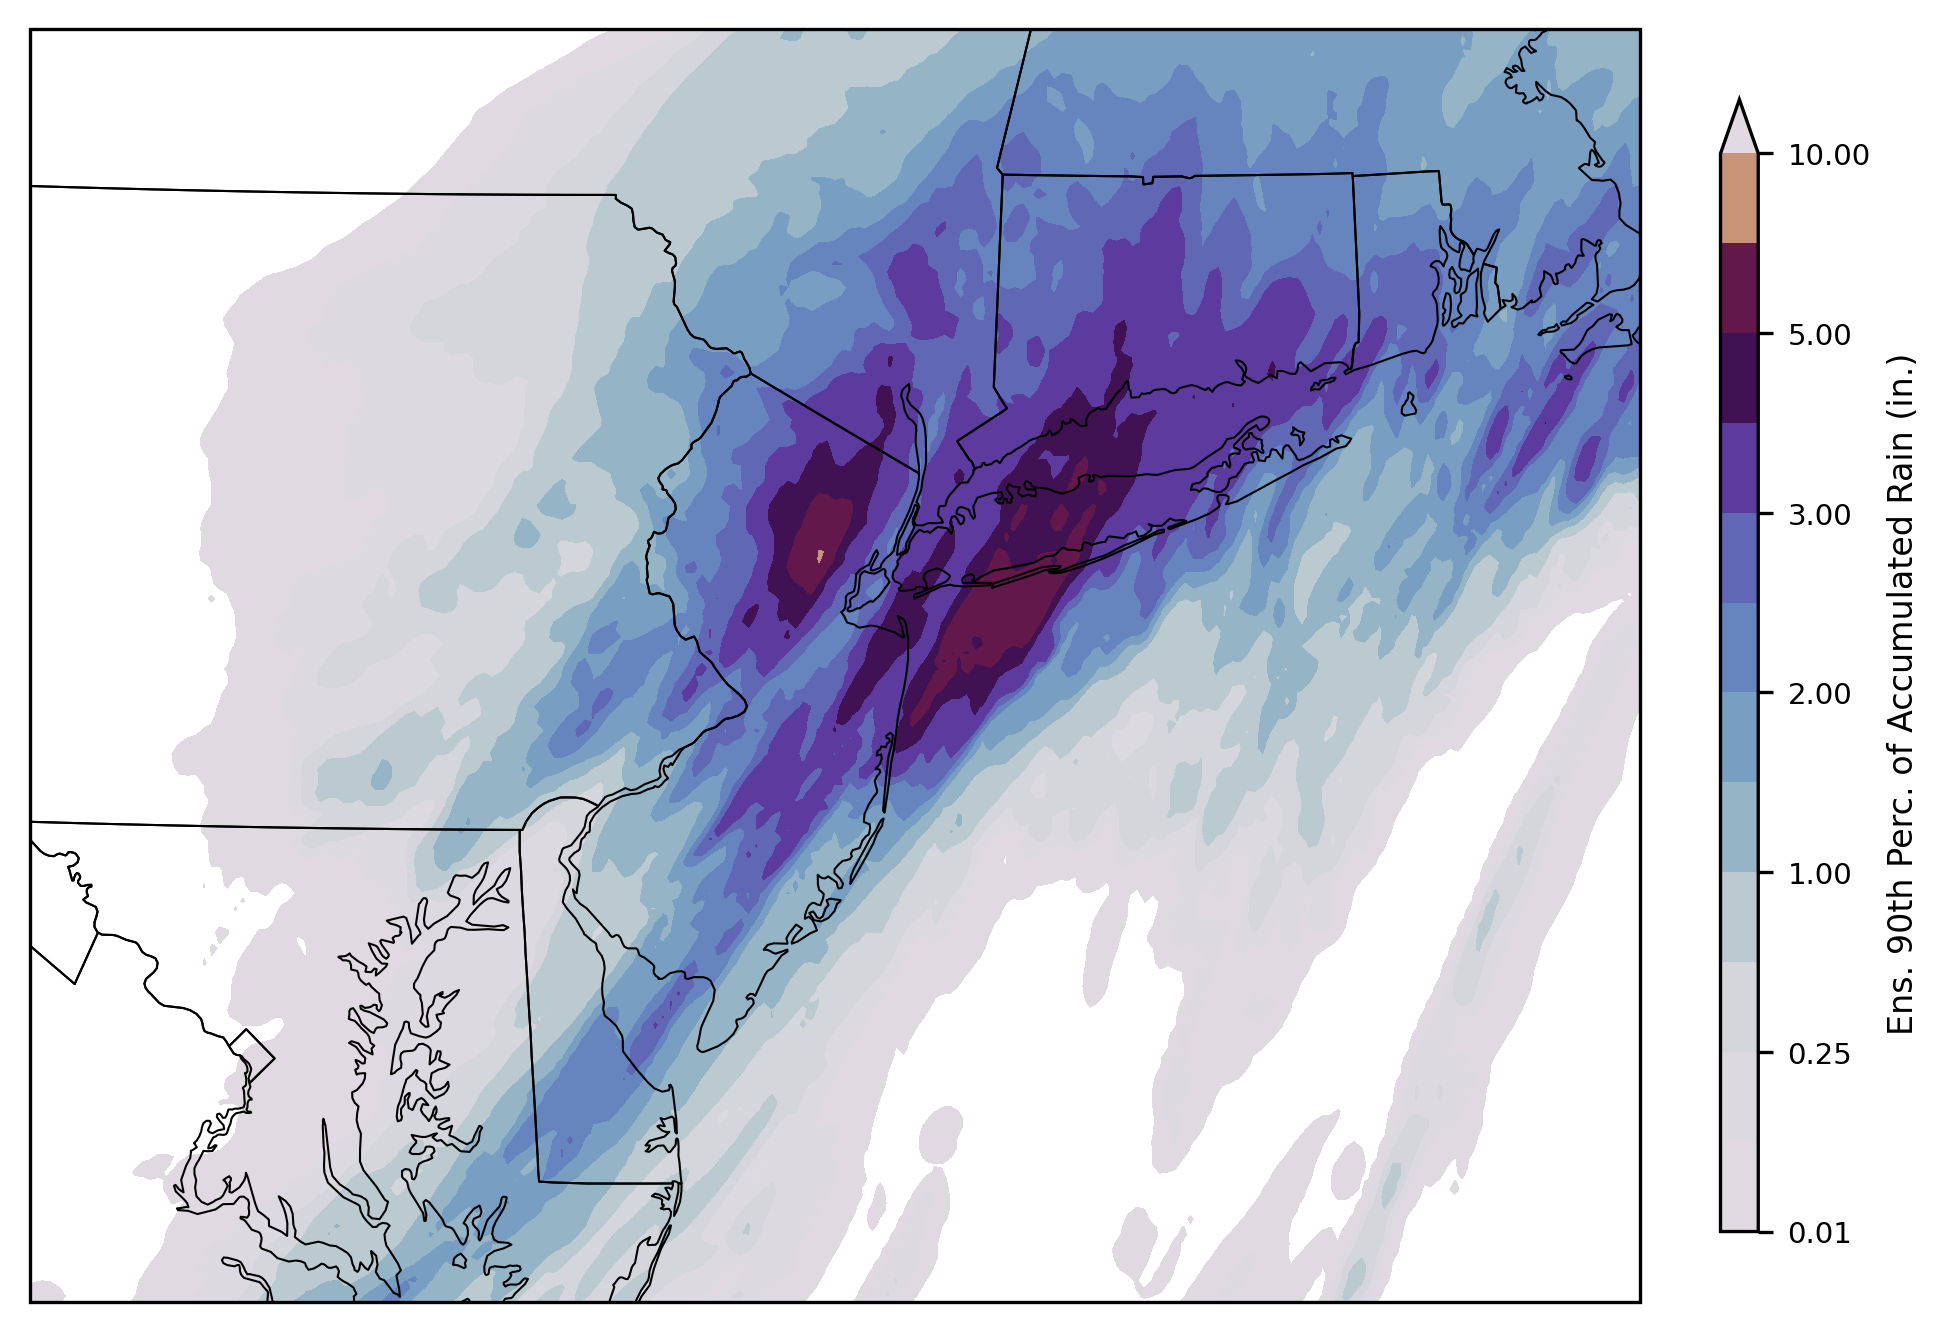

In [26]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
p = ax.contourf(lon,lat,rainnc_90/25.4,
                transform=ccrs.PlateCarree(),
                cmap="twilight",
                levels=[
                    0.01,0.10,0.25,0.50,1.00,1.50,2.00,2.50,3.00,4.00,5.00,7.00,10.00
                ],
                extend="max"
)
p.axes.set_extent(region,crs=ccrs.PlateCarree())
p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
# plt.subplots_adjust(wspace=0.04,hspace=0.04)
# plt.suptitle("5-min 0-2km helicity maxima",fontsize=9,fontweight='bold')

cbar = fig.colorbar(p,ax=ax,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Ens. 90th Perc. of Accumulated Rain (in.)",fontsize=8)

plt.show()

In [27]:
rainnc_max = rainnc_6hr.max(dim='ens')

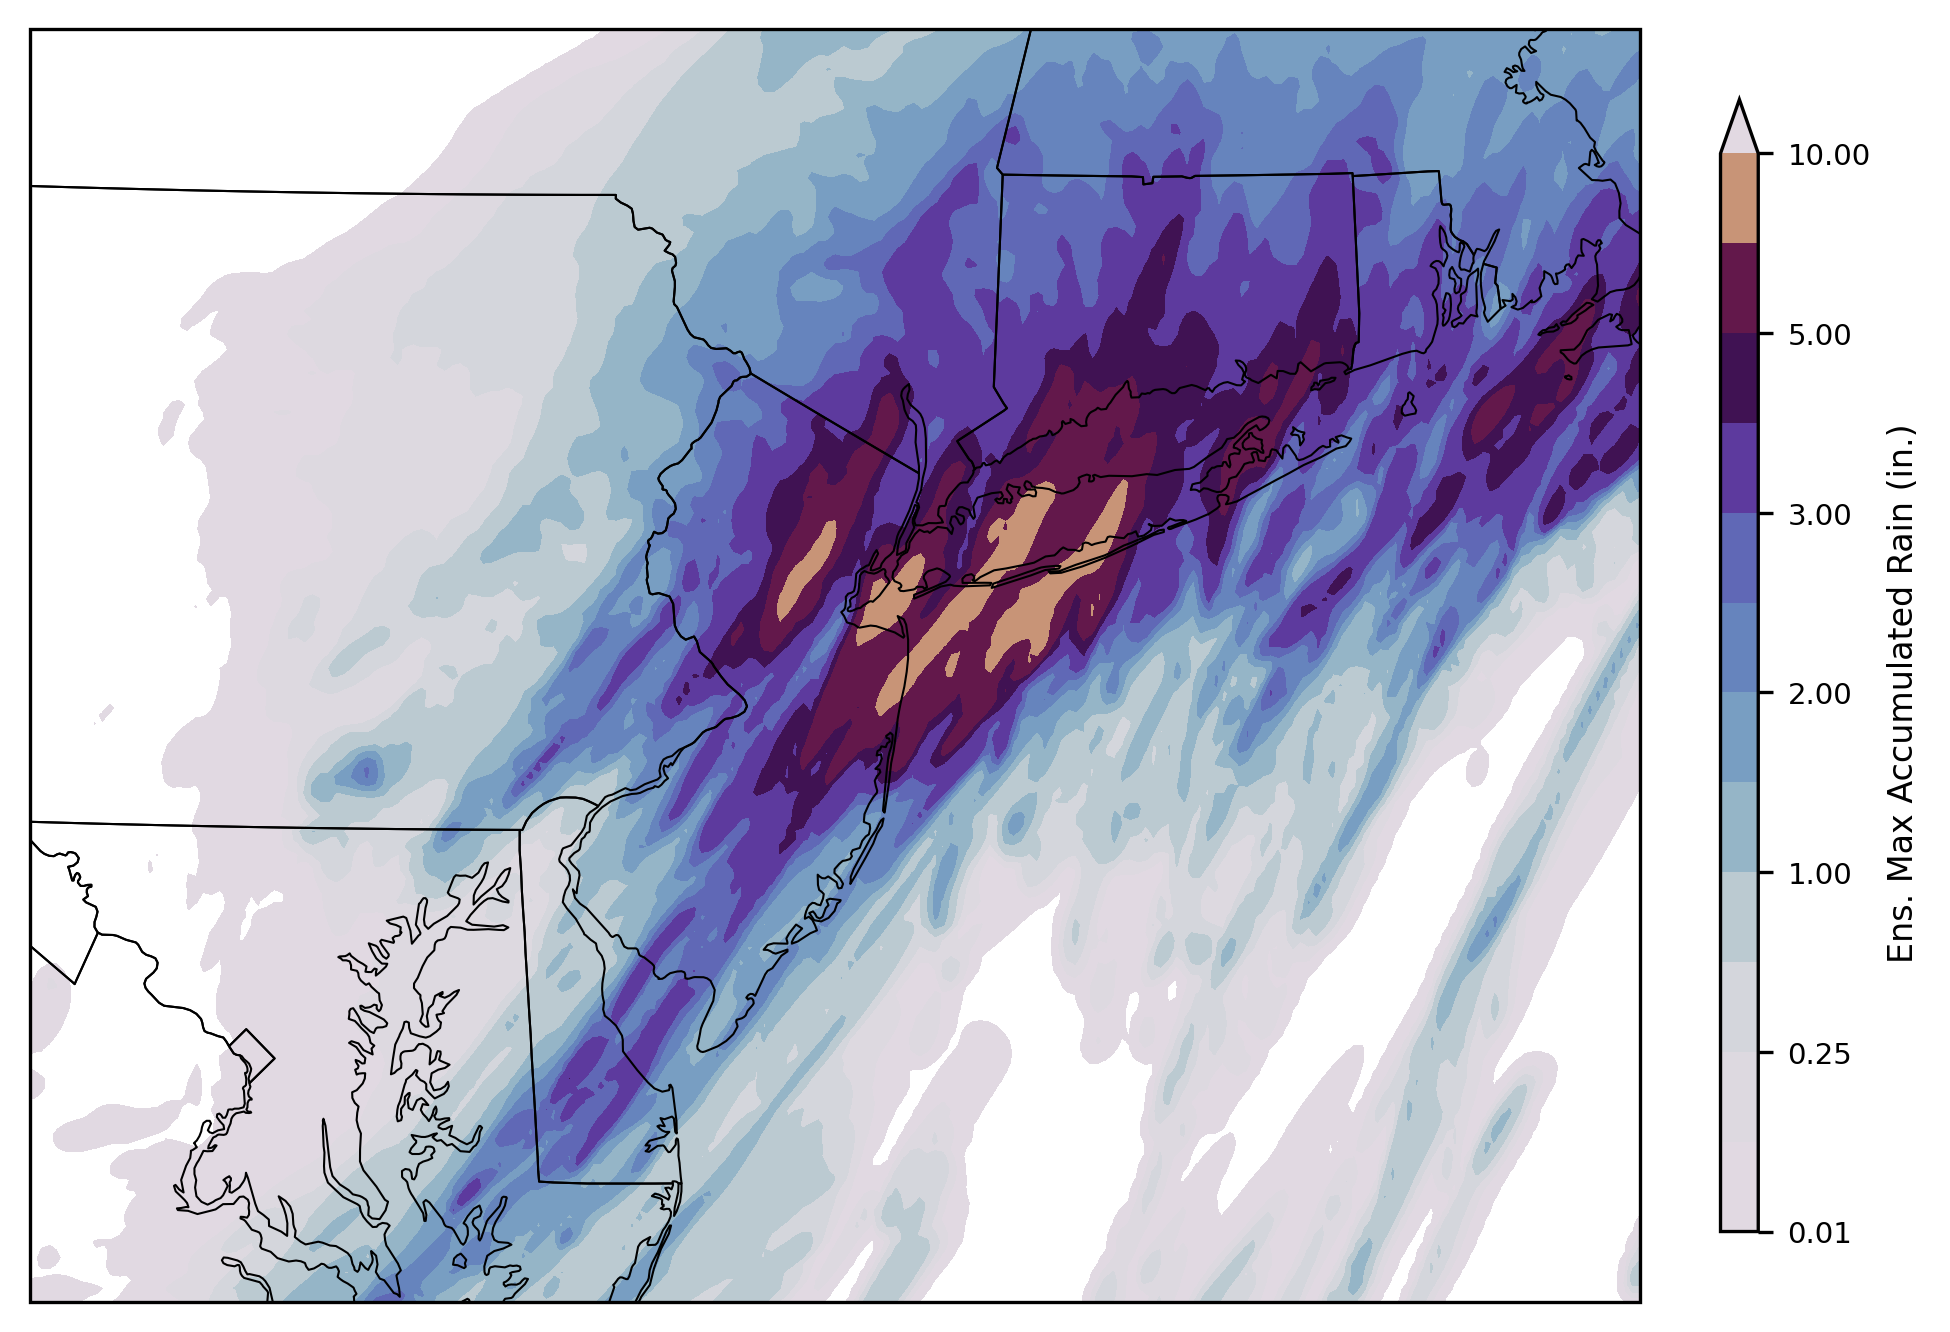

In [28]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)


fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")
p = ax.contourf(lon,lat,rainnc_max/25.4,
                transform=ccrs.PlateCarree(),
                cmap="twilight",
                levels=[
                    0.01,0.10,0.25,0.50,1.00,1.50,2.00,2.50,3.00,4.00,5.00,7.00,10.00
                ],
                extend="max"
)
p.axes.set_extent(region,crs=ccrs.PlateCarree())
p.axes.add_feature(cfeature.STATES,linewidth=linewidth)
# plt.subplots_adjust(wspace=0.04,hspace=0.04)
# plt.suptitle("5-min 0-2km helicity maxima",fontsize=9,fontweight='bold')

cbar = fig.colorbar(p,ax=ax,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("Ens. Max Accumulated Rain (in.)",fontsize=8)

plt.show()

In [42]:
rainnc.Time.where(rainnc.XTIME=='2021-09-02 00:00:00')

<xarray.DataArray 'Time' (Time: 73)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    XTIME    (Time) datetime64[ns] 2021-09-02 ... 2021-09-02T06:00:00
Dimensions without coordinates: Time

In [55]:
foo = pd.to_datetime('2021-09-02 01:00:00')
np.datetime64(foo)

numpy.datetime64('2021-09-02T01:00:00.000000')

In [56]:
rainnc.XTIME == np.datetime64(foo)

<xarray.DataArray 'XTIME' (Time: 73)>
array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])
Coordinates:
    XTIME    (Time) datetime64[ns] 2021-09-02 ... 2021-09-02T06:00:00
Dimensions without coordinates: Time